# Computer Graphics - Assignment 1

### Initialization

In [1]:
%matplotlib inline

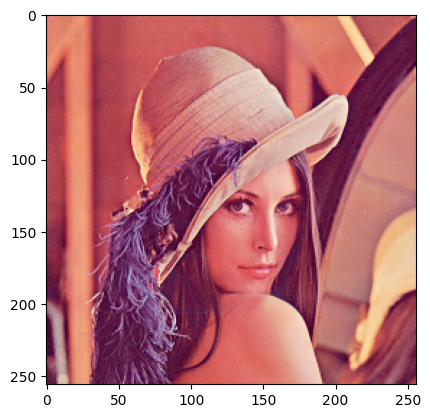

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread('res/Lenna.png')  # Replace with your image path
height, width, channels = image.shape

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Grayscale

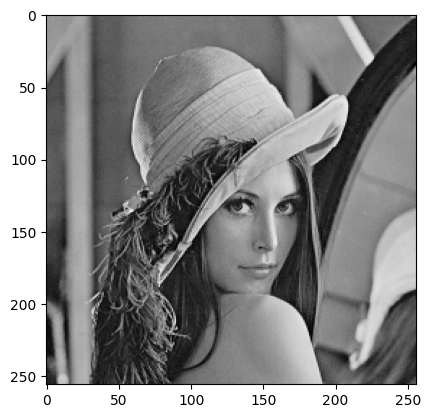

In [3]:
grayscale_image = np.zeros((height, width), dtype=np.uint8)
for y in range(height):
    for x in range(width):
        blue, green, red = image[y, x]
        gray_value = int(0.2989 * red + 0.587 * green + 0.114 * blue)
        grayscale_image[y, x] = gray_value


cv2.imwrite("res/Grayscale.png", grayscale_image)
plt.imshow(grayscale_image, cmap='gray')

### Canny

#### Noise reduction using Gaussian Filter

In [4]:
def apply_gaussian_filter(image, kernel_size=3, sigma=1):
    # Creating the Gaussian Kernel, each entry is computed using the Gaussian formula based on its distance from the center.
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    offset = kernel_size // 2
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - offset
            y = j - offset
            kernel[i, j] = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2)) # 2D Gaussian formula
    # The kernel values are normalized so that their sum equals 1, ensuring no brightness change in the image
    kernel /= kernel.sum()
    # To handle edge pixels during convolution, the image is padded with zeros around its borders
    padded_image = np.pad(image, ((offset, offset), (offset, offset)), mode='constant')
    smoothed_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract a region of the image corresponding to the kernel size, multiply element-wise with the Gaussian kernel, sum the result to compute the smoothed value for the central pixel
            smoothed_image[i, j] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size] * kernel)
    return smoothed_image.astype(np.uint8)

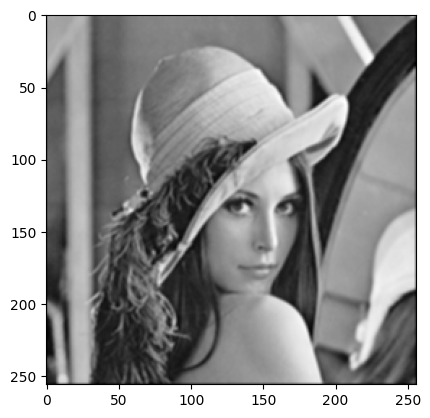

In [5]:
smoothed_image = apply_gaussian_filter(grayscale_image)
plt.imshow(smoothed_image, cmap='gray')

#### Gradient Calculation along the horizontal and vertical axis

In [6]:
def compute_gradients(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    gradient_x = np.zeros_like(image, dtype=np.float32)
    gradient_y = np.zeros_like(image, dtype=np.float32)
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant') # To handle edge pixels, pad the image with zeros (1-pixel padding for a 3x3 kernel)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            gradient_x[i, j] = np.sum(padded_image[i:i+3, j:j+3] * sobel_x)
            gradient_y[i, j] = np.sum(padded_image[i:i+3, j:j+3] * sobel_y)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_magnitude = (gradient_magnitude / gradient_magnitude.max() * 255).astype(np.uint8)
    gradient_direction = np.arctan2(gradient_y, gradient_x)
    return gradient_magnitude, gradient_direction

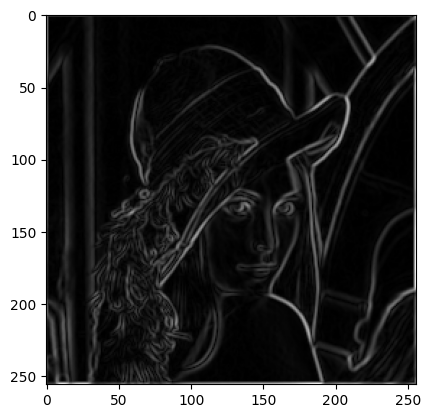

In [7]:
gradient_magnitude, gradient_direction = compute_gradients(smoothed_image)
plt.imshow(gradient_magnitude, cmap='gray')

#### Non-Maximum Suppression of false edges

In [8]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    suppressed_image = np.zeros_like(gradient_magnitude, dtype=np.uint8)
    angle = gradient_direction * 180.0 / np.pi
    angle[angle < 0] += 180
    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            try:
                direction = angle[i, j]
                pos_neighbor = 255
                neg_neighbor = 255
                if (0 <= direction < 22.5) or (157.5 <= direction <= 180):
                    # Horizontal edges (0°): Compare with left and right neighbors
                    pos_neighbor = gradient_magnitude[i, j + 1]  # Right neighbor
                    neg_neighbor = gradient_magnitude[i, j - 1]  # Left neighbor
                elif 22.5 <= direction < 67.5:
                    # Diagonal edges (45°): Compare with top-right and bottom-left neighbors
                    pos_neighbor = gradient_magnitude[i + 1, j - 1]  # Bottom-left neighbor
                    neg_neighbor = gradient_magnitude[i - 1, j + 1]  # Top-right neighbor
                elif 67.5 <= direction < 112.5:
                    # Vertical edges (90°): Compare with top and bottom neighbors
                    pos_neighbor = gradient_magnitude[i + 1, j]  # Bottom neighbor
                    neg_neighbor = gradient_magnitude[i - 1, j]  # Top neighbor
                elif 112.5 <= direction < 157.5:
                    # Diagonal edges (135°): Compare with top-left and bottom-right neighbors
                    pos_neighbor = gradient_magnitude[i - 1, j - 1]  # Top-left neighbor
                    neg_neighbor = gradient_magnitude[i + 1, j + 1]  # Bottom-right neighbor
                if (gradient_magnitude[i, j] >= pos_neighbor) and (gradient_magnitude[i, j] >= neg_neighbor):
                    suppressed_image[i, j] = gradient_magnitude[i, j]
                else:
                    suppressed_image[i, j] = 0
            except IndexError as e:
                pass
    return suppressed_image

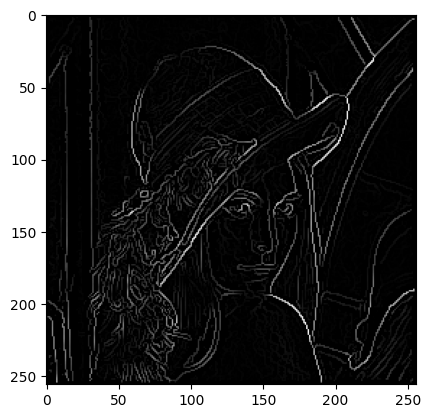

In [9]:
non_max_suppressed = non_max_suppression(gradient_magnitude, gradient_direction)
plt.imshow(non_max_suppressed, cmap='gray')

#### Double thresholding

In [10]:
def double_threshold(image, low_threshold, high_threshold):
    strong_pixel = 255
    weak_pixel = 50
    result = np.zeros_like(image, dtype=np.uint8)
    strong_i, strong_j = np.where(image >= high_threshold)
    weak_i, weak_j = np.where((image >= low_threshold) & (image < high_threshold))
    zero_i, zero_j = np.where(image < low_threshold)
    
    result[strong_i, strong_j] = strong_pixel
    result[weak_i, weak_j] = weak_pixel
    result[zero_i, zero_j] = 0

    return result

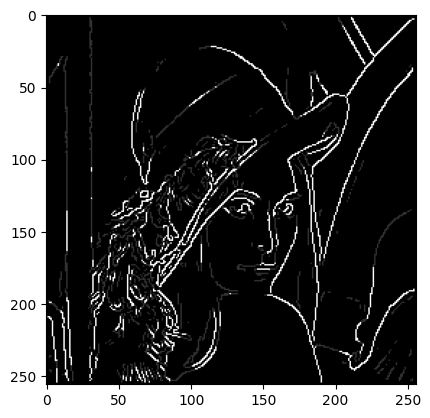

In [11]:
thresholded = double_threshold(non_max_suppressed, low_threshold=25, high_threshold=50)
plt.imshow(thresholded, cmap='gray')

#### Edge Tracking using Hysteresis

In [12]:
def edge_tracking_by_hysteresis(image):
    strong_pixel = 255
    weak_pixel = 50
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i, j] == weak_pixel:
                # Check if any of the 8 neighbors is a strong edge
                if strong_pixel in [image[i + a, j + b] for a in [-1, 0, 1] for b in [-1, 0, 1] if (a, b) != (0, 0)]:
                    # Promote weak edge to strong edge
                    image[i, j] = strong_pixel
                else:
                    # Suppress weak edge
                    image[i, j] = 0
    return image

True

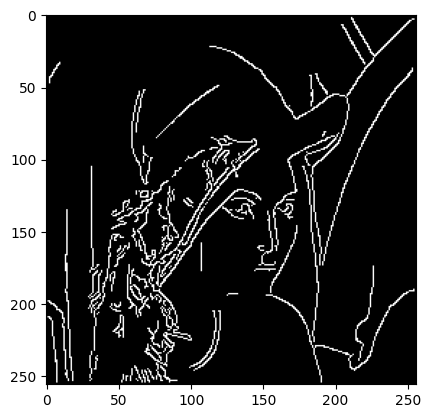

In [13]:
final_edges = edge_tracking_by_hysteresis(thresholded)
plt.imshow(final_edges, cmap='gray')
cv2.imwrite("res/Canny.png", final_edges)

### Halftone

In [19]:
def create_halftone_with_reference(image):
    # Ensure the input image is 256x256
    input_size = 256
    output_size = input_size * 2
    if image.shape[:2] != (input_size, input_size):
        image = cv2.resize(image, (input_size, input_size), interpolation=cv2.INTER_LINEAR)

    # Normalize intensity values to [0, 1]
    normalized_image = image / 255.0

    # Create a blank output image (512x512)
    halftone_image = np.zeros((output_size, output_size), dtype=np.uint8)

    # Define the dot placement mapping for 2x2 blocks
    block_mappings = {
        0: [],  # No dots
        1: [(0, 1)],  # Bottom-left
        2: [(0, 1), (1, 0)],  # Bottom-left, Top-right
        3: [(0, 1), (1, 0), (1,1)],  # Bottom-left, Top-right, Bottom-right
        4: [(0, 0), (0, 1), (1, 0), (1,1)]  # All quadrants
    }

    # Map each pixel to its halftone block
    for i in range(input_size):
        for j in range(input_size):
            # Get the normalized intensity of the current pixel
            intensity = normalized_image[i, j]

            # Determine the level based on intensity
            if 0 <= intensity < 0.2:
                level = 0
            elif 0.2 <= intensity < 0.4:
                level = 1
            elif 0.4 <= intensity < 0.6:
                level = 2
            elif 0.6 <= intensity < 0.8:
                level = 3
            else:  # 0.8 <= intensity <= 1.0
                level = 4

            # Get the 2x2 block coordinates in the output image
            start_x, start_y = 2 * i, 2 * j

            # Place dots in the block based on the level
            for dx, dy in block_mappings[level]:
                halftone_image[start_x + dx, start_y + dy] = 255

    return halftone_image

True

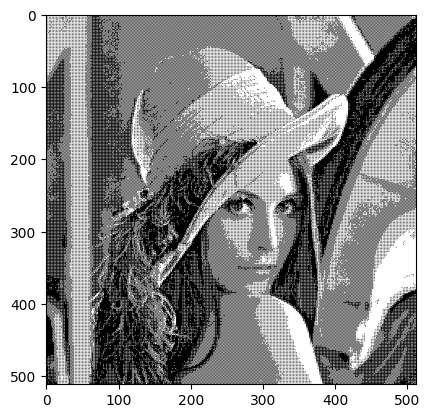

In [20]:
halftone_image = create_halftone_with_reference(grayscale_image)
plt.imshow(halftone_image, cmap='gray')
cv2.imwrite("res/Halftone.png", halftone_image)

### Floyd-Steinberg dithering

In [21]:
def floyd_steinberg_dithering(image, num_levels=16):
    # Define intensity levels
    levels = np.linspace(0, 255, num_levels).astype(np.uint8)

    # Convert image to float for precise error calculation
    dithered_image = image.astype(np.float32)

    # Loop through each pixel in the image
    for i in range(dithered_image.shape[0]):
        for j in range(dithered_image.shape[1]):
            # Find the nearest intensity level
            old_pixel = dithered_image[i, j]
            new_pixel = levels[np.argmin(np.abs(levels - old_pixel))]
            dithered_image[i, j] = new_pixel

            # Compute the quantization error
            error = old_pixel - new_pixel

            # Initialize neighbor weights
            weights = {
                "right": 7 / 16,
                "bottom_left": 3 / 16,
                "bottom": 5 / 16,
                "bottom_right": 1 / 16
            }

            # Adjust weights for edge cases
            valid_neighbors = []
            if j + 1 < dithered_image.shape[1]:  # Right
                valid_neighbors.append(("right", i, j + 1))
            else:
                weights.pop("right")

            if i + 1 < dithered_image.shape[0] and j - 1 >= 0:  # Bottom-left
                valid_neighbors.append(("bottom_left", i + 1, j - 1))
            else:
                weights.pop("bottom_left")

            if i + 1 < dithered_image.shape[0]:  # Bottom
                valid_neighbors.append(("bottom", i + 1, j))
            else:
                weights.pop("bottom")

            if i + 1 < dithered_image.shape[0] and j + 1 < dithered_image.shape[1]:  # Bottom-right
                valid_neighbors.append(("bottom_right", i + 1, j + 1))
            else:
                weights.pop("bottom_right")

            # Normalize weights for remaining neighbors
            total_weight = sum(weights.values())
            for key in weights:
                weights[key] /= total_weight

            # Diffuse error to valid neighbors
            for neighbor, ni, nj in valid_neighbors:
                dithered_image[ni, nj] += error * weights[neighbor]

    # Clip pixel values to stay in valid range [0, 255]
    dithered_image = np.clip(dithered_image, 0, 255)

    # Convert to uint8 for saving and visualization
    return dithered_image.astype(np.uint8)

True

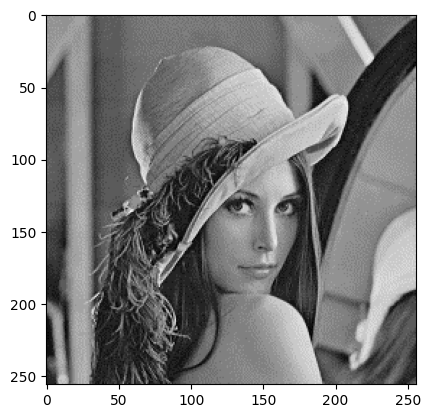

In [22]:
dithered_image = floyd_steinberg_dithering(grayscale_image)
plt.imshow(dithered_image, cmap='gray')
cv2.imwrite("res/FloyedSteinberg.png", dithered_image)